In [ ]:
!pip install segmentation_models_pytorch

     |████████████████████████████████| 88 kB 3.3 MB/s 
     |████████████████████████████████| 376 kB 11.0 MB/s 
     |████████████████████████████████| 58 kB 6.4 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=6d21eb969d731466fbe3d3afdcdf8d10df66c3dc177961c2359c7b410716feb0
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=2975e1d57ed64a23848445b77413ed42b7d68b2ce5a4a78fdf26ca0559cc29df
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
import os
import time

from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2

import torch

import torch
from torch import nn, optim

import segmentation_models_pytorch as smp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATASET_FILEPATH = Path('/content/drive/MyDrive/lips/')
IMAGES = '720p'
MASKS = 'mask'
LIST_CSV = 'list.csv'

In [ ]:
IMAGES_FILEPATH = DATASET_FILEPATH.joinpath(IMAGES)
MASKS_FILEPATH = DATASET_FILEPATH.joinpath(MASKS)
LIST_CSV_FILEPATH = DATASET_FILEPATH.joinpath(LIST_CSV)

In [ ]:
df_lips_images = pd.read_csv(LIST_CSV_FILEPATH)
df_lips_images.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [ ]:
feats = ['filename', 'mask']

df_lips_images = df_lips_images[feats]
df_lips_images.head()

,filename,mask
0,image00000001.jpg,mask00000001.png
1,image00000002.jpg,mask00000002.png
2,image00000003.jpg,mask00000003.png
3,image00000004.jpg,mask00000004.png
4,image00000005.jpg,mask00000005.png


In [ ]:
list_of_an_images = sorted([i for i in Path(IMAGES_FILEPATH).iterdir()])
list_of_a_masks = sorted([i for i in Path(MASKS_FILEPATH).iterdir()])

In [ ]:
len(list_of_an_images), len(list_of_a_masks)

(28594, 28540)

In [ ]:
df_lips_images = df_lips_images.loc[df_lips_images['mask'].isin([i.name for i in list_of_a_masks])]
df_lips_images.reset_index(drop=True, inplace=True)
df_lips_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28540 non-null  object
 1   mask      28540 non-null  object
dtypes: object(2)
memory usage: 446.1+ KB


In [ ]:
IMG_SIZE = 256

In [ ]:
def resize_an_image_and_mask(image_filename, mask_filename, new_size):

  image = cv2.imread(str(IMAGES_FILEPATH.joinpath(image_filename)))
  mask = cv2.imread(str(MASKS_FILEPATH.joinpath(mask_filename)))

  resized_image = cv2.cvtColor(cv2.resize(image, (new_size, new_size)), cv2.COLOR_BGR2RGB)
  resized_mask = cv2.cvtColor(cv2.resize(mask, (new_size, new_size)), cv2.COLOR_BGR2RGB)

  return resized_image, resized_mask

In [ ]:
class LipsDataset(torch.utils.data.Dataset):

  def __init__(self, data, preprocessing=None):

    self.data = data
    self.preprocessing = preprocessing

    self.images_paths = self.data.iloc[:, 0]
    self.masks_paths = self.data.iloc[:, 1]

    self.data_len = len(self.data.index)

  def __len__(self):
    return self.data_len

  def __getitem__(self, idx):

    img_path = self.images_paths[idx]
    mask_path = self.masks_paths[idx]

    img, mask = resize_an_image_and_mask(img_path, mask_path, IMG_SIZE)

    img = img.astype(float)

    if self.preprocessing:
      img = self.preprocessing(img)
      img = torch.as_tensor(img)
    else:
      img = torch.as_tensor(img)
      img /= 255.0

    img = img.permute(2, 0, 1)

    cls_mask_1 = mask[..., 1]

    cls_mask_1 = np.where(mask > 50, 1, 0)[:, :, 1]

    cls_mask_1 = cls_mask_1.astype('float')

    masks = [cls_mask_1]

    masks = torch.as_tensor(masks, dtype=torch.float)

    return img.float(), masks

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
from pandas.io.xml import preprocess_data
BACKBONE = 'resnet34'

segmodel = smp.Unet(encoder_name=BACKBONE, classes=1, activation='sigmoid')
segmodel.to(device)

preprocess_input = smp.encoders.get_preprocessing_fn(encoder_name=BACKBONE, pretrained='imagenet')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
X_train, X_valid = train_test_split(df_lips_images, test_size=0.3, random_state=42)

X_train.reset_index(drop=True, inplace=True)
X_valid.reset_index(drop=True, inplace=True)

train_data = LipsDataset(X_train, preprocessing=preprocess_input)
valid_data = LipsDataset(X_valid, preprocessing=preprocess_input)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=4, shuffle=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 256, 256])
torch.Size([8, 1, 256, 256])
tensor(0.) tensor(1.)


TypeError: ignored

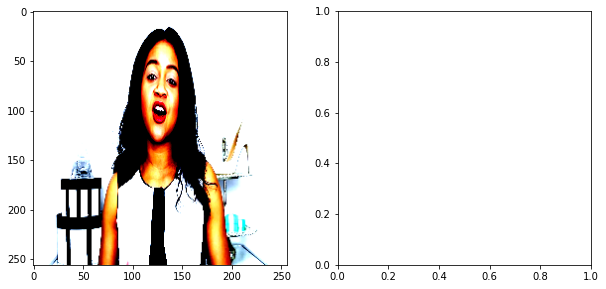

In [ ]:
for imgs, masks in train_loader:
  print(imgs.shape)
  print(masks.shape)
  print(masks.min(), masks.max())
  fig, ax = plt.subplots(1, 2, figsize=(10, 10))
  ax[0].imshow(imgs[0].permute(1, 2, 0))
  ax[1].imshow(masks[0].permute(1, 2, 0))
  break

In [ ]:
criterion = smp.utils.losses.BCELoss()
metrics = [smp.utils.metrics.IoU(),]
optimizer = optim.Adam(segmodel.parameters(), lr=0.001)

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    segmodel,
    loss=criterion,
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True
)

In [ ]:
valid_epoch = smp.utils.train.ValidEpoch(
    segmodel,
    loss=criterion,
    metrics=metrics,
    device=device,
    verbose=True
)

In [ ]:
# train model

max_score = 0

for i in range(0, 1):
  print(f'Epoch: {i + 1}')
  train_logs = train_epoch.run(train_loader)
  valid_logs = valid_epoch.run(valid_loader)

  # do something (save_model, change lr, etc.)
  if max_score < valid_logs['iou_score']:
    max_score = valid_logs['iou_score']
    torch.save(segmodel, '/content/drive/MyDrive/lips/best_model.pth')
    print('Model saved!')

Epoch: 1
train:  62%|██████▏   | 1548/2498 [2:11:38<1:21:49,  5.17s/it, bce_loss - 0.01141, iou_score - 0.7626]

In [ ]:
data_iter = iter(train_loader)

In [ ]:
images, labels = data_iter.next()
images, labels = images.t(device), labels.to(device)

outputs = segmodel(images)

In [ ]:
for i in range(images.shapes[0]):
  fig, (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16, 5))

  image = images[i].permute(1, 2, 0)

  ax_1.imshow(image.cpu())
  ax_1.set_title('Image')

  ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0))
  ax_2.set_title('True_mask')

  ax_3.imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0))
  ax_3.set_title('Pred_mask')